In [1]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
torch.__version__

(1450, 400)
(400, 400)
coherence of data:  0.7119395644427652


'2.0.1'

In [9]:
#Raw data training
starttime=time.time()
target='raw'
labeled_data=2000
layer_loss_list=[]
Epochs=1000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data

wand_dict={}
batchsize=128
layers=[64]*11
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
valloader=DataLoader(val_data,batch_size=512,shuffle=True,num_workers=0)
encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        if labeled_data==1:
            b=b.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)  
            rho=rho.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)
        font_size = 50
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid':
            #rho_hat=rho_hat-rho
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        if encoder_out=='sigmoid' or encoder_out=='softmax':
            #print(rho_hat.shape, rh.shape)
            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            bce_loss.backward() 
            train_lossavg+=bce_loss.item()/len(trainloader)

        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            L2_loss.backward()
            train_lossavg+=L2_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    wand_dict['train loss']=train_lossavg
    val_loss=0
    encoder.eval()
    for batch, (b,rho,num_targets) in enumerate(valloader):
        b=b.to(device)
        rho=rho.to(device)    
        font_size = 50
        rho_hat=encoder(b)
        if encoder_out=='sigmoid':
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid' or encoder_out=='softmax':

            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            val_loss+=bce_loss.item()/len(valloader)
        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            val_loss+=L2_loss.item()/len(valloader)
    wand_dict['val loss']=val_loss
    if epoch==Epochs-1:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    if Track_run:
        wandb.log(wand_dict)

if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (2000, 400), B: (2000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
591664
Data shapes: 1450.0 200.0


KeyboardInterrupt: 

Medium: (1450, 400), Rho: (40000, 400), B: (40000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
2961100
Data shapes: 1450.0 200.0


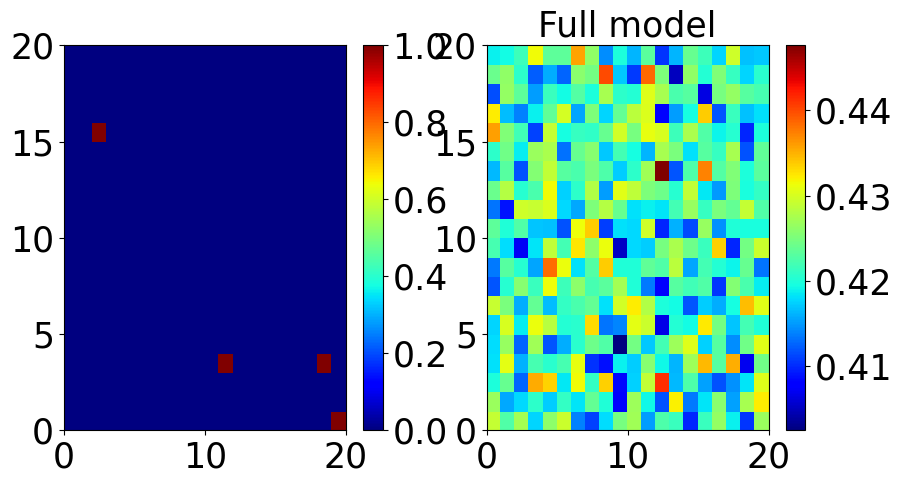

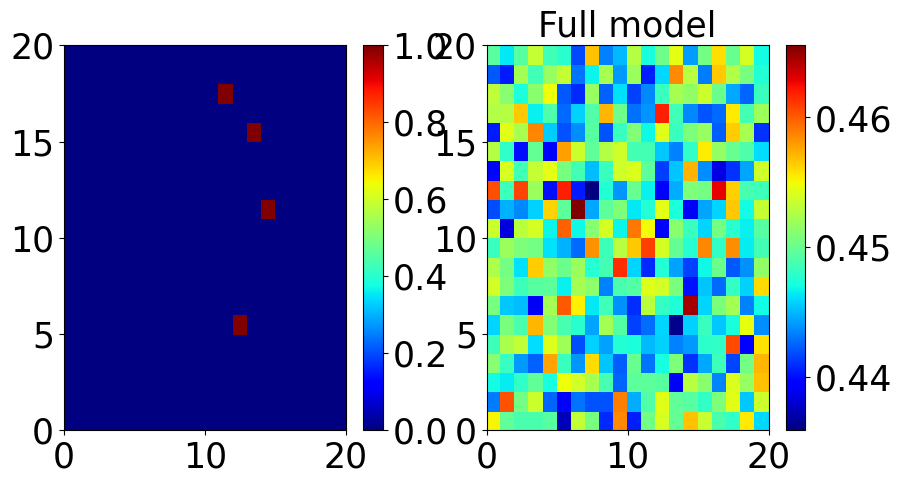

epoch: 0, train loss: 0.04297496797368169, L1 loss: 0.4644603905035183, val loss: 0.038590963929891586, max avg inners: 0.06795191856651547, GELMA loss: -1, num indices: 0
epoch: 1, train loss: 0.03669580550620352, L1 loss: 0.042806777855730616, val loss: 0.03609864413738251, max avg inners: 0.07150752685242219, GELMA loss: -0.26923738238870953, num indices: 0
epoch: 2, train loss: 0.03554847807929918, L1 loss: 0.07216412996058352, val loss: 0.03491276130080223, max avg inners: 0.08240234152666448, GELMA loss: -0.5462337249184657, num indices: 0
epoch: 3, train loss: 0.03416672135932377, L1 loss: 0.0886877387529239, val loss: 0.03345363587141037, max avg inners: 0.09726808099373217, GELMA loss: 0.018732345535843464, num indices: 0
epoch: 4, train loss: 0.032706800669717324, L1 loss: 0.08710071597306523, val loss: 0.03210435435175896, max avg inners: 0.11495158036109865, GELMA loss: 0.13478893001739323, num indices: 0
epoch: 5, train loss: 0.031160500162420952, L1 loss: 0.09859330930339

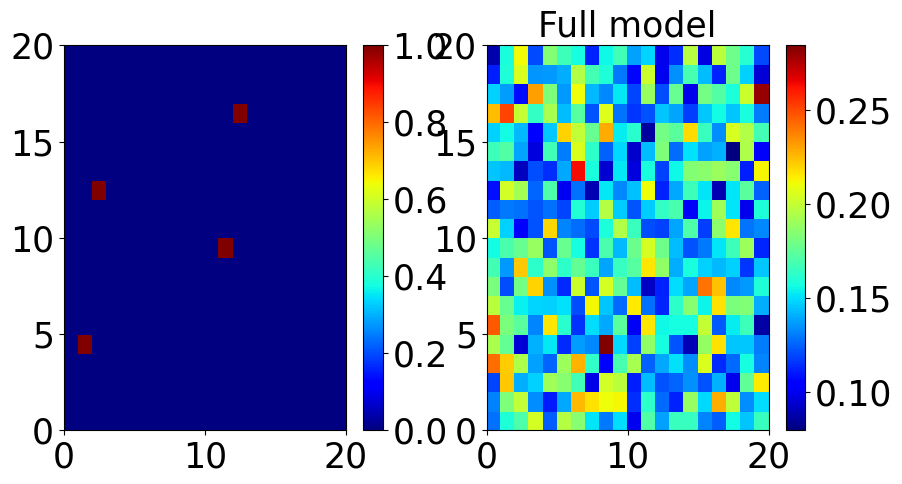

epoch: 100, train loss: 0.005528197355996878, L1 loss: 0.16999783838400617, val loss: 0.009060232900083065, max avg inners: 0.2661850541708022, GELMA loss: 0.015832878411115026, num indices: 0
epoch: 101, train loss: 0.005476997229464042, L1 loss: 0.16916883396334015, val loss: 0.009126014076173306, max avg inners: 0.2664167684223849, GELMA loss: 0.06479075609355789, num indices: 0
epoch: 102, train loss: 0.0054659428902137, L1 loss: 0.17036487406585366, val loss: 0.009016635827720165, max avg inners: 0.26665723992989354, GELMA loss: 0.0565192163903827, num indices: 0
epoch: 103, train loss: 0.00547328326232231, L1 loss: 0.16678819520166144, val loss: 0.009167094714939594, max avg inners: 0.2669197123114433, GELMA loss: 0.0004899354034450243, num indices: 0
epoch: 104, train loss: 0.005460406844013222, L1 loss: 0.1686994801275432, val loss: 0.009008568711578846, max avg inners: 0.267106442878388, GELMA loss: 0.0729940760613168, num indices: 0
epoch: 105, train loss: 0.00541204089870135

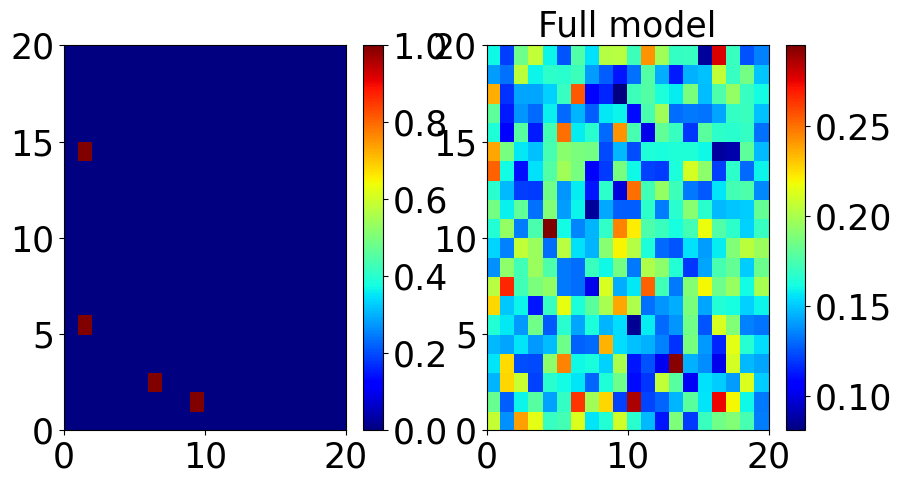

epoch: 200, train loss: 0.004556915962312831, L1 loss: 0.1756395613483619, val loss: 0.008590244688093662, max avg inners: 0.2932629705535609, GELMA loss: 0.03791904290562087, num indices: 0
epoch: 201, train loss: 0.004546372777821062, L1 loss: 0.17543727153679356, val loss: 0.008674862794578075, max avg inners: 0.2935515211594923, GELMA loss: -0.005982769401419175, num indices: 0
epoch: 202, train loss: 0.0045254290142593455, L1 loss: 0.17569094779901206, val loss: 0.008649887517094612, max avg inners: 0.29386586527940217, GELMA loss: 0.05710862338581534, num indices: 0
epoch: 203, train loss: 0.0045336293541609115, L1 loss: 0.17307618691120297, val loss: 0.008699330501258373, max avg inners: 0.2941735445099413, GELMA loss: 0.06432678695267313, num indices: 0
epoch: 204, train loss: 0.004535815142952022, L1 loss: 0.17253747500944883, val loss: 0.008607469499111176, max avg inners: 0.2944858278339958, GELMA loss: -0.02231516707529302, num indices: 0
epoch: 205, train loss: 0.004531989

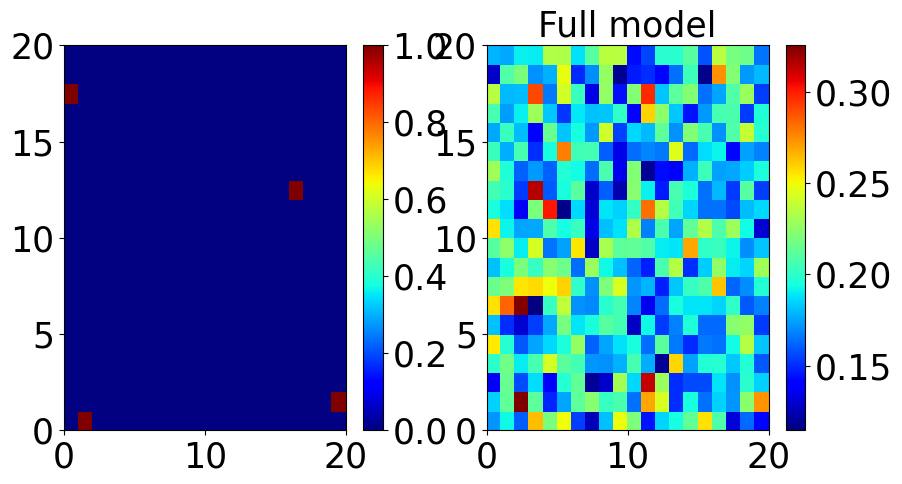

epoch: 300, train loss: 0.004225811910645939, L1 loss: 0.1764623993949499, val loss: 0.00850987434387207, max avg inners: 0.3300436456486815, GELMA loss: -0.027776128619372287, num indices: 0
epoch: 301, train loss: 0.0042283882747014495, L1 loss: 0.1783494371920824, val loss: 0.008613153360784054, max avg inners: 0.3304632816559311, GELMA loss: 0.04730617286785588, num indices: 0
epoch: 302, train loss: 0.004253854848646795, L1 loss: 0.17427573766326532, val loss: 0.00854155607521534, max avg inners: 0.33090881985174986, GELMA loss: -0.04335097558705314, num indices: 0
epoch: 303, train loss: 0.0042356003281145615, L1 loss: 0.17537166058900766, val loss: 0.008705624379217625, max avg inners: 0.3313360048055053, GELMA loss: 0.0782335377036425, num indices: 0
epoch: 304, train loss: 0.004232672644189944, L1 loss: 0.17640182704781182, val loss: 0.008500820957124233, max avg inners: 0.33176721043286056, GELMA loss: -0.027047046893824422, num indices: 0
epoch: 305, train loss: 0.0042288965

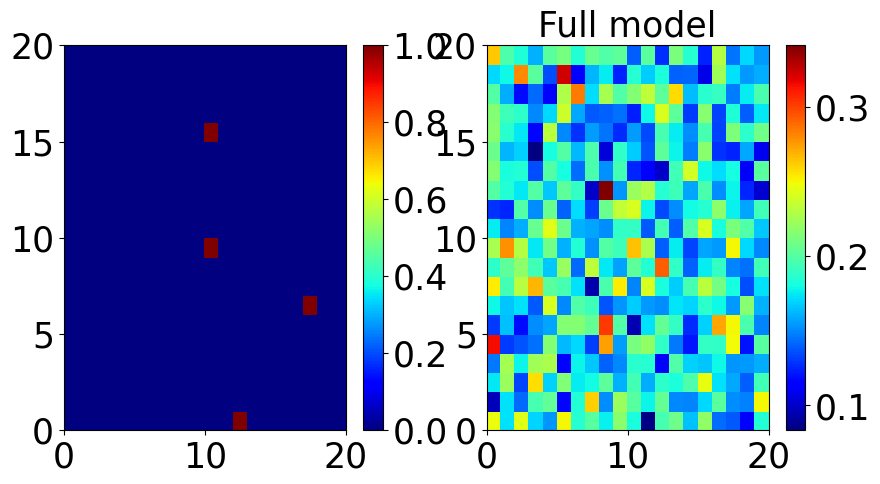

epoch: 400, train loss: 0.004100083772200177, L1 loss: 0.17362774087814614, val loss: 0.008515377528965473, max avg inners: 0.37930656326650386, GELMA loss: 0.016858212742443257, num indices: 0
epoch: 401, train loss: 0.004105834437671085, L1 loss: 0.17459433365729637, val loss: 0.008607170544564724, max avg inners: 0.3798869801000456, GELMA loss: 0.03020876951365103, num indices: 0
epoch: 402, train loss: 0.004081945176780839, L1 loss: 0.17327682144241408, val loss: 0.008523140102624893, max avg inners: 0.3804409088020766, GELMA loss: 0.07211884561764137, num indices: 0
epoch: 403, train loss: 0.00408419802451667, L1 loss: 0.17697799194138497, val loss: 0.008504186756908894, max avg inners: 0.3809959810766641, GELMA loss: -0.021082732781785296, num indices: 0
epoch: 404, train loss: 0.004096199213095696, L1 loss: 0.1742569475027267, val loss: 0.008545304648578167, max avg inners: 0.3815538962875861, GELMA loss: 0.005416135422098289, num indices: 0
epoch: 405, train loss: 0.00408842844

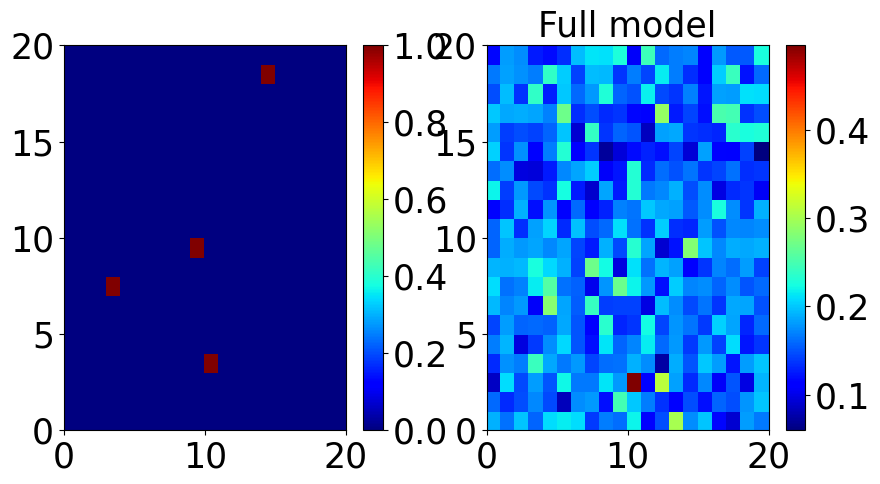

epoch: 500, train loss: 0.004011868266388775, L1 loss: 0.17329235561192036, val loss: 0.008477107621729374, max avg inners: 0.441526655664455, GELMA loss: 0.002029002183281947, num indices: 0
epoch: 501, train loss: 0.003982041248331623, L1 loss: 0.16997157217701897, val loss: 0.008570973761379719, max avg inners: 0.4422170902138416, GELMA loss: 0.03172961893227466, num indices: 0
epoch: 502, train loss: 0.003971713685844175, L1 loss: 0.17114363799919374, val loss: 0.008500318974256516, max avg inners: 0.4429141743847646, GELMA loss: 0.04167479208949665, num indices: 0
epoch: 503, train loss: 0.003976346755299135, L1 loss: 0.16957366824499331, val loss: 0.00852852500975132, max avg inners: 0.44355465280930106, GELMA loss: -0.056265107156727716, num indices: 0
epoch: 504, train loss: 0.003978206933038637, L1 loss: 0.168452625075588, val loss: 0.008390887640416622, max avg inners: 0.4442655122642535, GELMA loss: -0.007046023053208782, num indices: 0
epoch: 505, train loss: 0.003974995848

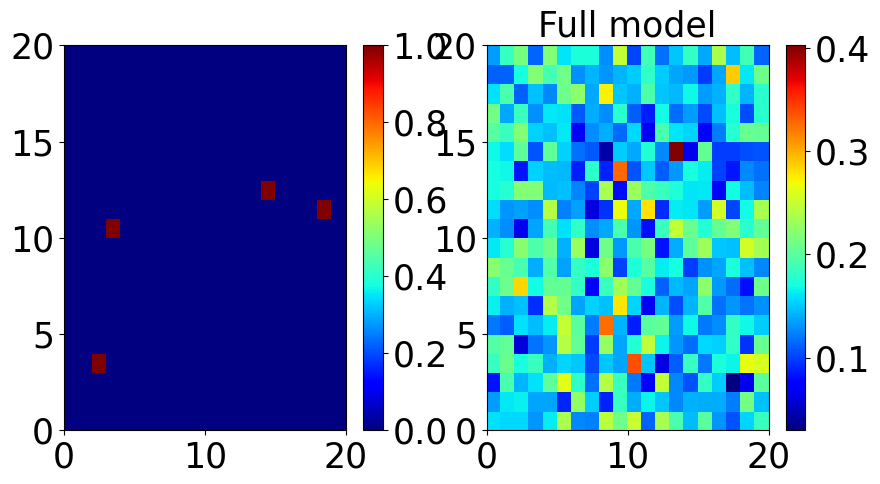

epoch: 600, train loss: 0.0038802912488532125, L1 loss: 0.1620757939235773, val loss: 0.008360384032130241, max avg inners: 0.5128930267261775, GELMA loss: -0.09180023408106308, num indices: 2
epoch: 601, train loss: 0.0038913460366558805, L1 loss: 0.16311027138726786, val loss: 0.008476737886667252, max avg inners: 0.513600864154629, GELMA loss: 0.02283282070358883, num indices: 2
epoch: 602, train loss: 0.003876548071507924, L1 loss: 0.16294814486172982, val loss: 0.008484899066388607, max avg inners: 0.5143061332272731, GELMA loss: 0.005725901523756516, num indices: 2
epoch: 603, train loss: 0.003872997601317192, L1 loss: 0.16245152437477373, val loss: 0.008450217545032501, max avg inners: 0.5150706433554489, GELMA loss: 0.013149450278637786, num indices: 2
epoch: 604, train loss: 0.0038739889726256984, L1 loss: 0.1609902574273292, val loss: 0.008459381759166718, max avg inners: 0.51580429897657, GELMA loss: -0.014793525779377424, num indices: 2
epoch: 605, train loss: 0.00386793626

In [3]:
#Raw data training unlabeled only
starttime=time.time()
target='raw'
unlabeled_data=40000
batchsize=128
L1_weight=5e-5
layers=[250,250,250,150,150,200,400]
GELMA_layers=layers#[500,500,500,300,300,400,800]
CE=False
KM_in=False
INV_weight=0
RESHUFFLE=False

GELMA=5e-10
G_0=False
Epochs=3000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2


encoder=M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
#decoder=M.fc_net_extra(outdim, layers[::-1], indim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if KM_in:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                Mhat_imag=-Mhat_imag
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                In_put=torch.cat((b, km_b), dim=-1)

                rho_hat=encoder(In_put)
            else:
                rho_hat=encoder(b)
            rho_hat=sigmoid(rho_hat)
            #rho_hat=softmax(rho_hat)

            b_hat=decoder(rho_hat)
            if INV_weight>0:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                complex_mat=Mhat_real+1j*Mhat_imag
                #print(f'og complex mat shape: {complex_mat.shape}')
                complex_mat=complex_mat.T #yes
                complex_mat=torch.linalg.pinv(complex_mat.T.conj()@complex_mat, hermitian=True)@complex_mat.T.conj()  
                complex_b=b_real+1j*b_imag
                complex_b=complex_b.T
                #print(complex_mat.shape, complex_b.shape)

                rho_inv=complex_mat@complex_b
                rho_inv=rho_inv.T
                rho_inv_real=rho_inv.real
                rho_inv_imag=rho_inv.imag
                INV_loss=L2_loss_fn(rho_inv_real, rho_hat)*INV_weight
                INV_loss.backward(retain_graph=True)
                INV_loss=INV_loss.item()/INV_weight
                if INV_weight<5e-3:
                    INV_weight=INV_weight*1.011


                
                
                




            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss=L1_loss.item()/L1_weight
            else:
                L1_loss=-1

            if CE:
                rho_hat_hat=encoder(b_hat)

                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
                CEloss.backward(retain_graph=True)
                CEloss=CEloss.item()

            
            if GELMA>0 and epoch>0:
                optimizer_GELMA.zero_grad()
                GELMA_out=GELMA_net(b).squeeze()
                b_hat=b_hat.squeeze()
                GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
                inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
                inner_loss_term.backward(retain_graph=True)
                inner_loss_term_avg=inner_loss_term.item()/GELMA
                optimizer_GELMA.step()
                
            else:
                inner_loss_term_avg=-1
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()


            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()/len(trainloader)
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    #rho_hat=softmax(rho_hat)

    b_hat=decoder(rho_hat) 
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training unlabeled no batching
starttime=time.time()
target='raw'
unlabeled_data=4000
batchsize=128
L1_weight=1e-15
layers=[5000,5000,5000,3000,3000,1400,800]
#layers.append(256)
GELMA_layers=[500,500,500,300,300,400,800]
CE=False
KM_in=False
#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2


encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
b_train=training_data.b.to(device)
rho_train=training_data.rho.to(device)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    if True:
        b=b_train
        rho=rho_train
        optimizer.zero_grad()
        optimizer_decod.zero_grad()
        if KM_in:
            medium_hat=decoder(Complex_eye).squeeze()
            medium_hat=F.normalize(medium_hat, dim=-1)
            Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
            Mhat_imag=-Mhat_imag
            b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
            km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
            km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

            km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
            
        # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
            In_put=torch.cat((b, km_b), dim=-1)

            rho_hat=encoder(In_put)
        else:
            rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)

        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss=L1_loss.item()/L1_weight
        else:
            L1_loss=-1

        if CE:
            rho_hat_hat=encoder(b_hat)

            CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
            CEloss.backward(retain_graph=True)
            CEloss=CEloss.item()

        
        if GELMA>0 and epoch>100:
            optimizer_GELMA.zero_grad()
            GELMA_out=GELMA_net(b)
            GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
            inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
            inner_loss_term.backward(retain_graph=True)
            inner_loss_term_avg=inner_loss_term.item()/GELMA
            optimizer_GELMA.step()
            
        else:
            inner_loss_term_avg=-1
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        optimizer_decod.step()
        train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    #if epoch%10000==0:
    #   H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training variational autoencoder (KL replcaed with BCE)
starttime=time.time()
target='raw'
unlabeled_data=5000
batchsize=128
layers=[500,500,500,300,300,300,400,800]
G_0=False
Epochs=10000
index_list=[]
KL_weight=1
L1_weight=1e-3

Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=512
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)

encoder=M.variational_enc(training_data.b[0].shape[0]/2, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
decoder=M.fc_net_extra(outdim, [layers[len(layers)-i-1] for i in range(len(layers))],training_data.b[0].shape[0]/2 , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)

if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
L1_loss_fn=nn.L1Loss()
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)

lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    encoder.train()
    decoder.train()
    KL_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        b=b.to(device)
        rho=rho.to(device)

        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        rho_hat_mean, rho_hat_logvar=encoder(b)
        rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
        KLloss=H.KL_divergence(rho_hat_mean, rho_hat_logvar)*KL_weight
        KLloss.backward(retain_graph=True)
        #rho_hat=sigmoid(rho_hat)

        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss=L1_loss.item()/L1_weight
        else:
            L1_loss=-1

        b_hat=decoder(rho_hat)
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        optimizer_decod.step()
        train_lossavg+=L2_loss.item()/len(trainloader)
        KL_lossavg+=KLloss.item()/len(trainloader)/KL_weight
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat_mean, rho_hat_logvar=encoder(b_val)
    rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
    #rho_hat=softmax(rho_hat)
    #rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        #Complex_eye=Complex_eye+
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, KL_LOSS: {KL_lossavg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original},  num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training unlabeled only. Encoder decoder alternation
starttime=time.time()
target='raw'
unlabeled_data=10000
L1_weight=0.005
GELMA=0.0
G_0=False
Epochs=100000
layers=[128]*14
GELMA_layers=[128]*5
GELMA_layers.append(500)
layers.append(500)



Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128

#training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
b=training_data.b.to(device)
rho=training_data.rho.to(device)
rh_t, _=torch.split(rho, 400, dim=-1)


#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)

encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.Adam(decoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)

if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.AdamW(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()


for epoch in range(Epochs):
    encoder.train()
    decoder.train()
    train_lossavg=0
    train_lossavg=0
    train_lossavg_decoder=0
    inner_loss_term_avg=0
    L1_loss_avg=0
    for param in encoder.parameters():
        param.requires_grad = True
    for i in range(15):
        optimizer.zero_grad()
        optimizer_decod.zero_grad()


        font_size = 50
        rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)
        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss_avg+=L1_loss.item()/L1_weight/15
            #if L1_loss>5e-15:
                #L1_weight=L1_weight*0.999
        else:
            L1_loss=-1

        if GELMA>0:
            optimizer_GELMA.zero_grad()
            GELMA_out=GELMA_net(b)
            GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
            inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
            inner_loss_term.backward(retain_graph=True)
            inner_loss_term_avg+=inner_loss_term.item()/GELMA/15
            optimizer_GELMA.step()
        else:
            inner_loss_term_avg=-1
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


    
        optimizer.step()
        train_lossavg+=L2_loss.item()/15
    for param in encoder.parameters():
        param.requires_grad = False


    for i in range(15):
        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        font_size = 50
        rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)


        
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()



        optimizer_decod.step()
        train_lossavg_decoder+=L2_loss.item()/15
    
    
    val_lossavg=0
    if epoch%1000==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%1000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%100==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
            index_of_max=np.argmax(torch_inners[:,i])
            torch_inners[:,index_of_max]=0*torch_inners[index_of_max,:]
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        
        
        
        print(f'epoch: {epoch}, Encoder train loss: {train_lossavg}, Decoder train loss: {train_lossavg_decoder} L1 loss: {L1_loss_avg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}')
        
    if Track_run:
        wandb.log(wand_dict)


if Track_run:
    wandb.finish()


In [ ]:
#cc data training
starttime=time.time()
target='raw'
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')

labeled_data=400
layer_loss_list=[]
Epochs=3000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1, medium='homo')
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)


b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)


val_data=H.data_rho_CC(data_path+'/val', 3000/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)

encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

if torch.allclose(b_train, b_val):
    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.CrossEntropyLoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    bce_loss.backward() 
    train_lossavg+=bce_loss.item()
    accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%1000==0:
        H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    val_loss+=bce_loss.item()
    accuracy_val=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()
    if epoch%1000==0:
        H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}, train accuracy: {accuracy_train}, val accuracy: {accuracy_val}')


torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt')

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


In [ ]:
#loads orderer network, 'orderer' saved Decoder model located at 'locat'. Then reorderes the decoder columns into
#the variable 'G_hat_permed'. Reordering is done by placing the column with the highest probability into the correct predicted position.
#this is repeated until the entire matrix is reordered.
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net_lowcow.pt'
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt'
#save_lcation:"/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)"
orderer.load_state_dict(torch.load(Locat_orderer))

layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
decoder=nn.Linear(400,training_data[0][0].shape[0], bias=False)
locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' # .71 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_long_bigdata/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_30-May-2024 (23:10:16)decoder.pt' #.61 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (23:10:30)decoder.pt' #.41 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (21:26:12)decoder.pt' #.41 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (23:29:19)decoder.pt' #.92 random init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)decoder.pt' #.92 G_0 init


decoder.load_state_dict(torch.load(locat))


Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
cc_medium=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    cc_medium.append(outer)

cc_medium=np.array(cc_medium)
print(outer.shape, cc_medium.shape)
cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1)
print(cc_medium.shape)
Perm=orderer(cc_medium)

softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
T=[]
print(Perm.shape)
for i in range(len(Perm)):
    largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    Perm[:,indices_1[overall_max_index]]=0


print(G_hat_permed.shape, medium_hat.shape)
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 12124.0 400.0
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
(12124,) (400, 12124)
torch.Size([400, 24248])
torch.Size([400, 400])
(400, 1450) (400, 1450)
0.9954802301497007


In [ ]:
#function doing above
def reorder_step(medium_hat):
    
    cc_medium=[]
    for i in range(len(medium_hat)):
        outer=np.outer(medium_hat[i],medium_hat[i].conj())
        outer=outer[abs(Mask)>0]
        outer=outer.ravel()
        cc_medium.append(outer)

    cc_medium=np.array(cc_medium)
    print(outer.shape, cc_medium.shape)
    cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1).float()
    print(cc_medium.shape)
    Perm=orderer(cc_medium)

    softmax=nn.Softmax(dim=1)
    Perm=softmax(Perm.squeeze())
    G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
    #G_hats_notremapped=[]
    for i in range(len(Perm)):
        largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
        overall_max_index=torch.argmax(largest)
        G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
        Perm[:,indices_1[overall_max_index]]=0


    return G_hat_permed

for i in range(1):
    torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
    print(sum(torch_inners.diagonal())/400)
    G_hat_permed=reorder_step(G_hat_permed)
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Permutes the columns with inerse perm matrix.
Perm=orderer(cc_medium)
softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
hope=torch.tensor(np.linalg.inv(Perm.cpu().detach().numpy())).round()
G_hat_permed_inver=medium_hat.squeeze().T@hope.cpu().detach().numpy().T
G_hat_permed_inver=torch.tensor(G_hat_permed_inver.T)
G_hat_permed_inver=F.normalize(G_hat_permed_inver, dim=-1)

torch_inners=np.abs(np.inner(G_hat_permed_inver,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Compares the behavior of different decoder networks trained with different random realizations and different
#SGD randomness. 
decoder=nn.Linear(400,1450*2, bias=False)
#locat="/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (00:41:20)decoder.pt"
locat1='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' 
locat2='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (10:33:30)decoder.pt'
locat3='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (07:51:38)decoder.pt'
locat4='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (02:50:48)decoder.pt'
locat5='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (20:36:55)decoder.pt'
locat_list=[locat1, locat2, locat3, locat4, locat5]
locat1_indlist=[]
locat2_indlist=[]
locat3_indlist=[]
locat4_indlist=[]
locat5_indlist=[]
total_list=[locat1_indlist, locat2_indlist, locat3_indlist, locat4_indlist, locat5_indlist]
for j in range(5):
    decoder.load_state_dict(torch.load(locat_list[j]))

    Complex_eye=torch.eye(400).unsqueeze(1)
    medium_hat=decoder(Complex_eye)
    medium_hat=medium_hat.squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
    larger_than=0
    sum_max_noreplace_original=0
    for i in range(400):
        if max(torch_inners[i,:])>.90:
            larger_than+=1
            total_list[j].append(i)
        sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat
    print(larger_than)    


In [ ]:
####Tests orderer on fully random data  
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
print(training_data.b.shape)
data_path_G0_list=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 

#original_G= np.array(mat73.loadmat(data_path_G0_list+'/rtt_array.mat')['RM_realization_list'])
print(original_G.shape)
training_data.b=original_G[58].T
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
softmax=nn.Softmax(dim=1)
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'

orderer.load_state_dict(torch.load(Locat_orderer))
orderer.to(device)
trainloader=DataLoader(training_data,batch_size=400,shuffle=True,num_workers=0)
orderer.train()
accuracy=0
lossavg=0
bce_loss_fn=nn.CrossEntropyLoss()   
for batch, (b,rho,num_targets) in enumerate(trainloader):

    b=b.to(device)
    rho=rho.to(device)    
    rho_hat=orderer(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    lossavg+=bce_loss.item()/len(trainloader)
    H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    accuracy+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()/len(trainloader)

print(f'accuracy: {accuracy}, loss: {lossavg}')


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
(400, 1450)


NameError: name 'original_G' is not defined

In [ ]:
#Plots the ordered decoder and the original KM image

torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()
    b=sensing@rho.T
    img=sensing_hat.T.conj()@b
    
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
#rho[37+20]=1
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
rho[210]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
KM_img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, SAME_bar=pcol_Used)
KM_img_hat(rho, medium, medium,xpix=20, ypix=20, SAME_bar=pcol_Used)

ValueError: shapes (400,1450) and (400,1450) not aligned: 1450 (dim 1) != 400 (dim 0)

0.9954802301497007
(1450, 400)


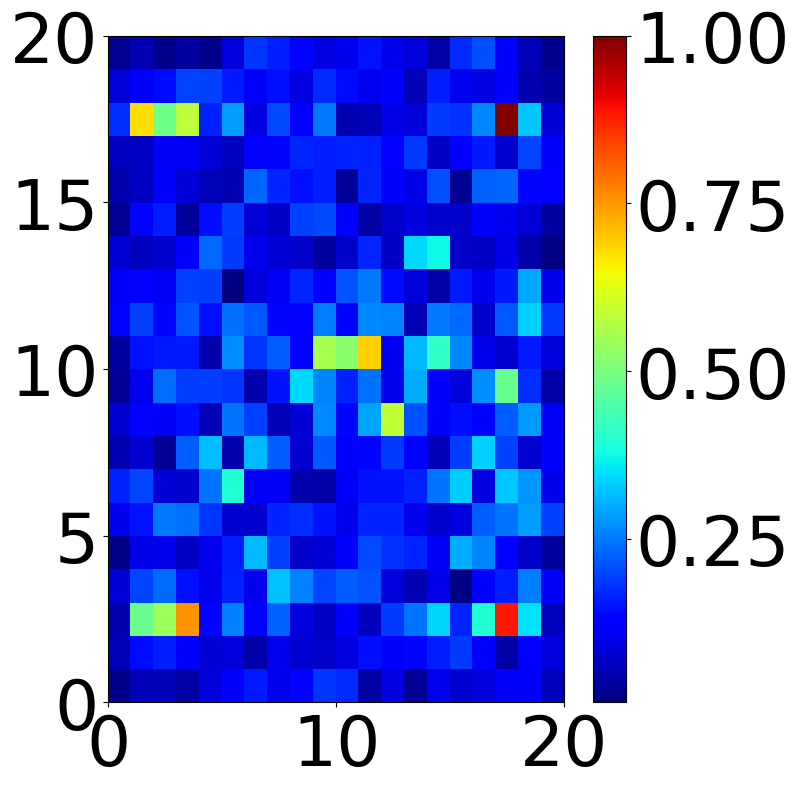

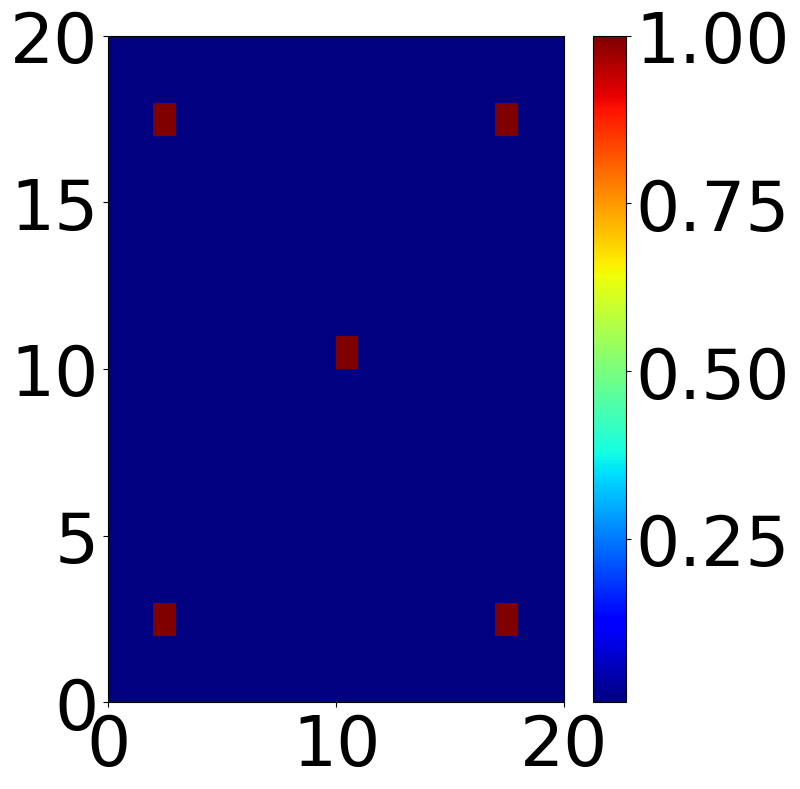

In [ ]:
#Plots the ordered decoder and the original KM image

torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()

    b=sensing@rho.T
    img=np.linalg.pinv(sensing_hat)@b
        
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    #cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
rho[37+20]=1
rho[22+20]=1
rho[400-22-1-20]=1
rho[400-37-1-20]=1
rho[210]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, file_name='rho_hat',SAME_bar=pcol_Used)
img_hat(rho, medium, medium,xpix=20, ypix=20, file_name='rho',SAME_bar=pcol_Used)

In [ ]:
#Raw data training unlabeled conv layers
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')

unlabeled_data=5000
batchsize=128
L1_weight=0
layers=[500,500,500,300,300,400,800]
#layers.append(256)
GELMA_layers=[32]*11
CE=False
KM_in=False

CONV=True

#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2

if CONV:
    encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='conv',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
else:
    encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
    
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if KM_in:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                Mhat_imag=-Mhat_imag
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                
            # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
                In_put=torch.cat((b, km_b), dim=-1)

                rho_hat=encoder(In_put)
            else:
                rho_hat=encoder(b)
            #if CONV:
            ##    rho_hat=rho_hat.squeeze()
            #    rho_hat=softmax(rho_hat)
            #    rho_hat=rho_hat*4
            #else:
            rho_hat=sigmoid(rho_hat)
            b_hat=decoder(rho_hat)

            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss=L1_loss.item()/L1_weight
            else:
                L1_loss=-1

            if CE:
                rho_hat_hat=encoder(b_hat)

                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
                CEloss.backward(retain_graph=True)
                CEloss=CEloss.item()

            
            if GELMA>0 and epoch>100:
                optimizer_GELMA.zero_grad()
                GELMA_out=GELMA_net(b)
                GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
                inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
                inner_loss_term.backward(retain_graph=True)
                inner_loss_term_avg=inner_loss_term.item()/GELMA
                optimizer_GELMA.step()
                
            else:
                inner_loss_term_avg=-1
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()


            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
  #  if epoch%10000==0:
      # H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/med_nets/CCorderer_fc_net_highcow.pt')
torch.save(decoder.state_dict(),f'/home/achristie/RM_imaging/models/med_nets/CCorderer_fc_net_highcow.pt')

if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)


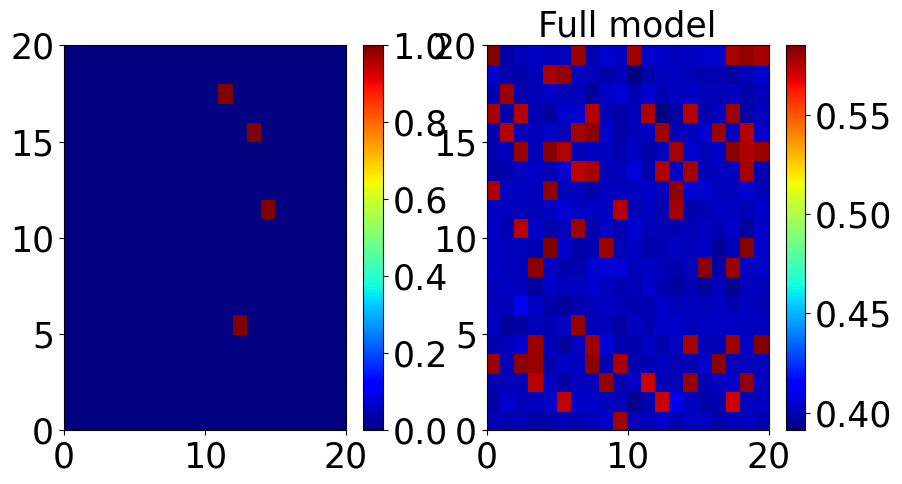

epoch: 0, train loss: 0.08238195357844233, L1 loss: -1, val loss: 0.040840476751327515, max avg inners: 0.06692334081398481, GELMA loss: -1, num indices: 0
epoch: 1, train loss: 0.03906469000503421, L1 loss: -1, val loss: 0.040266502648591995, max avg inners: 0.06693860468066912, GELMA loss: -1, num indices: 0
epoch: 2, train loss: 0.03866398204118013, L1 loss: -1, val loss: 0.04089730978012085, max avg inners: 0.0669359504410034, GELMA loss: -1, num indices: 0
epoch: 3, train loss: 0.03884156616404653, L1 loss: -1, val loss: 0.04138944670557976, max avg inners: 0.06692548815111707, GELMA loss: -1, num indices: 0
epoch: 4, train loss: 0.03890713751316071, L1 loss: -1, val loss: 0.04221049323678017, max avg inners: 0.0669634375464826, GELMA loss: -1, num indices: 0
epoch: 5, train loss: 0.03899692380800843, L1 loss: -1, val loss: 0.04126133769750595, max avg inners: 0.06694207509959113, GELMA loss: -1, num indices: 0
epoch: 6, train loss: 0.038981225993484254, L1 loss: -1, val loss: 0.0

In [ ]:
#raw data training unlabeled with Transformers
starttime=time.time()
target='raw'
unlabeled_data=5000
Epochs=1000  
batchsize=128
#layers.append(256)
layers=[1000,500,200]
Epochs=7000
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')



training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2



encoder_layer = nn.TransformerEncoderLayer(d_model=indim*2, nhead=10)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
connector=M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}

trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
L2_loss_fn=nn.MSELoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
optimizer = torch.optim.AdamW(transformer_encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)
optimizer_connector = torch.optim.AdamW(connector.parameters(), lr=0.001)
transformer_encoder.to(device)
decoder.to(device)
connector.to(device)
transformer_encoder.train()
decoder.train() 
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
sigmoid=nn.Sigmoid()
for epoch in range(Epochs):
    L1_loss=-1
    train_lossavg=0
    val_lossavg=0
    inner_loss_term_avg=-1
    transformer_encoder.train()
    decoder.train() 
    connector.train()
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        b=b.to(device)
        rho=rho.to(device)
        optimizer.zero_grad()
        optimizer_decod.zero_grad()
        optimizer_connector.zero_grad()
        rho_hat=connector(transformer_encoder(b))
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()
        optimizer.step()
        optimizer_decod.step()
        optimizer_connector.step()
        train_lossavg+=L2_loss.item()/len(trainloader)



    transformer_encoder.eval()
    decoder.eval()
    connector.eval()

    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    rho_hat=connector(transformer_encoder(b_val))
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()








    if epoch%10000==0:
        H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))

        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')


In [ ]:
#cc data training #(x, y) coords 
starttime=time.time()
target='raw'
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')

grid=np.array(mat73.loadmat(data_path+'/grid.mat')['full_grid'])
b_x=min(grid[:,0])
m_x=(max(grid[:,0])-min(grid[:,0]))
b_y=min(grid[:,1])
m_y=(max(grid[:,1])-min(grid[:,1]))
labeled_data=400
layer_loss_list=[]
Epochs=10000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC_XY_targs(data_path+'/train',labeled_data/80000,1, medium='homo')
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)


b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)


val_data=H.data_rho_CC_XY_targs(data_path+'/val', 3000/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)

encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

if torch.allclose(b_train, b_val):
    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%500==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%500==0:
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5, xpix=20, ypix=20, font_size=15)
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')


#torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt')

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)


KeyboardInterrupt: 

(400, 1450) (400, 1450)
shape of single cc entry: (12124,), norm of single cc entry: 0.999999967304575
(400, 1450)
rearranged average innter product: 0.9302892977489609
number of correctly (>.97 inner) placed elements: 355


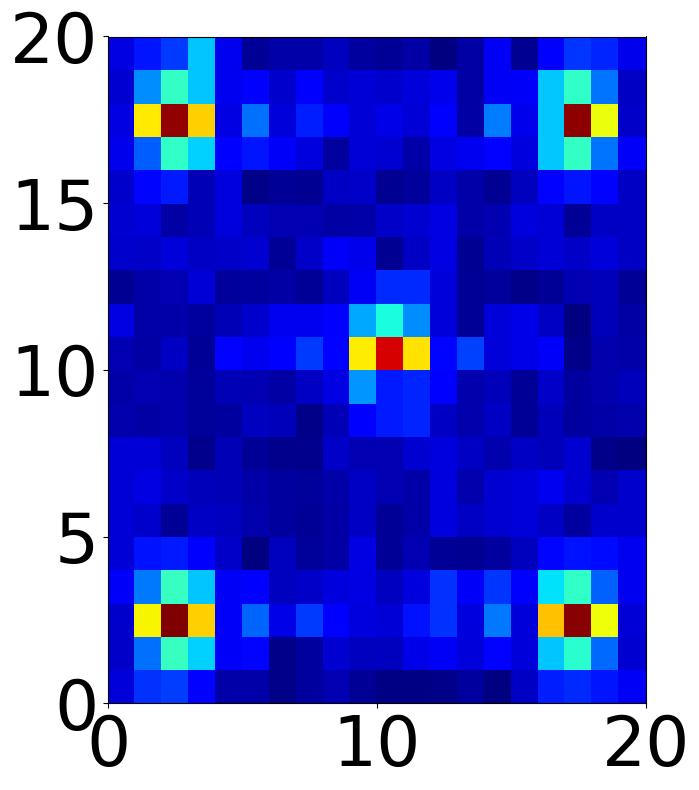

In [ ]:
#Checks if theres a clear 1-1 correspondence b/w ghat ghat^* and g g^*
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])

decoder=nn.Linear(400,1450*2, bias=False)
locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' # .71 G_0 init
decoder.load_state_dict(torch.load(locat))
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
medium=medium.T
print(medium_hat.shape, medium.shape)
cc_medium_hat=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    outer=outer/np.linalg.norm(outer)
    cc_medium_hat.append(outer)

test_entry=cc_medium_hat[0]
print(f'shape of single cc entry: {test_entry.shape}, norm of single cc entry: {sum(abs(test_entry)**2)}')


cc_medium_hat=np.array(cc_medium_hat)
cc_medium=[]
for i in range(len(medium)):
    outer=np.outer(medium[i],medium[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    outer=outer/np.linalg.norm(outer)
    cc_medium.append(outer)
cc_medium=np.array(cc_medium)

G_hat_permed=np.zeros_like(medium_hat)

torch_inners=np.abs(np.inner(cc_medium_hat,cc_medium.conj()) ) #entry i j is ghat_i dot bar(g_j) 
# mean over true max over hats
torch_inners=torch.tensor(torch_inners)
for i in range(400):
    largest,indices_1=torch.max(torch_inners, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    torch_inners[:,indices_1[overall_max_index]]=0

print(G_hat_permed.shape)
torch_inners=np.abs(np.inner(G_hat_permed,medium.conj()) ) #entry i j is ghat_i dot bar(g_j)
print(f'rearranged average innter product: {sum(torch_inners.diagonal())/400}')
print(f'number of correctly (>.97 inner) placed elements: {sum(torch_inners.diagonal()>.97)}')



rho=np.zeros((400))
rho=np.zeros((400))
rho[37+20]=1
rho[22+20]=1
rho[400-22-1-20]=1
rho[400-37-1-20]=1
rho[210]=1




sensing_hat=medium.T
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
KM_img_hat(rho, G_hat_permed.T, medium.T,xpix=20, ypix=20, SAME_bar=pcol_Used)




In [ ]:
#KM images with specifed grids

data_path=os.path.join(cwd,'Data/PNAS-regime_2xgrid_all_seeds/PNAS-regime_2xgrid_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])








def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()
    b=sensing@rho.T
    img=sensing_hat.T.conj()@b
    
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((3600))
#rho[37+20]=1
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
rho[int(60*60/2)+30]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(60, 60)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
KM_img_hat(rho, medium, medium,xpix=60, ypix=60, SAME_bar=pcol_Used)

In [3]:
#cc data training #(x, y) coords. Uses largexlarge grid for homo, and 20x20 for random
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-regime_2xgrid_all_seeds/PNAS-regime_2xgrid_seed0')
print

Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo', grid='grid_100by100.mat')

print('training data passed')
b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
print('billy')
data_path_val=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
val_data=H.data_rho_CC_XY_targs(data_path_val+'/val', 2/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)



encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

#if torch.allclose(b_train, b_val):
#    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%500==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%500==0:
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5, xpix=20, ypix=20, font_size=15)
        H.plot_2_imgs_XY_displacments((rho.squeeze()), (rho_hat.squeeze()), figsize=5, xpix=20, ypix=20, font_size=15)

        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')






FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/achristie/RM_imaging/RM_imaging/Data/PNAS-regime_2xgrid_all_seeds/PNAS-regime_2xgrid_seed0//G_0.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
training data passed
Medium: (1450, 10000), Rho: (10000, 10000), B: (10000, 1450)
Data shapes: 725.0 0.5
15318018
Data shapes: 725.0 0.5


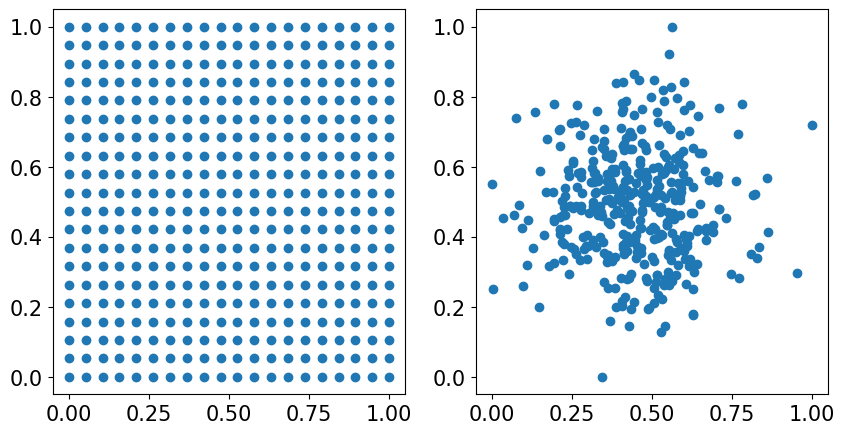

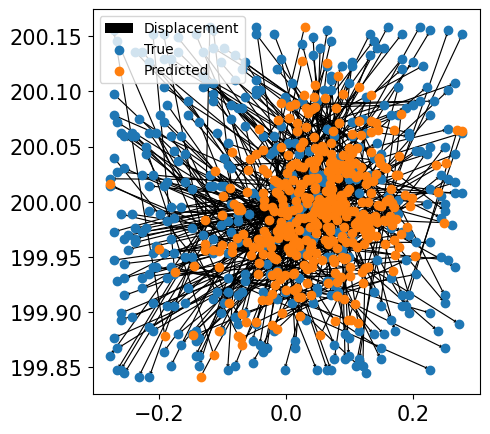

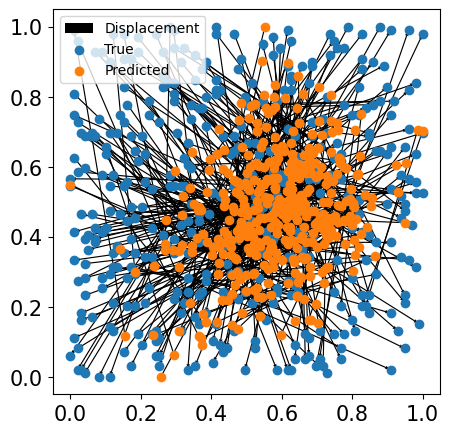

epoch: 0, train loss: 0.1272733509540558, val loss: 0.12859690189361572
epoch: 1, train loss: 0.1496925950050354, val loss: 0.055785730481147766
epoch: 2, train loss: 0.054013680666685104, val loss: 0.02780125103890896
epoch: 3, train loss: 0.030095886439085007, val loss: 0.023726390674710274
epoch: 4, train loss: 0.027181148529052734, val loss: 0.048578277230262756
epoch: 5, train loss: 0.04457686468958855, val loss: 0.020538613200187683
epoch: 6, train loss: 0.02601965330541134, val loss: 0.017503244802355766
epoch: 7, train loss: 0.02424188144505024, val loss: 0.013256884180009365
epoch: 8, train loss: 0.015862200409173965, val loss: 0.0076131802052259445
epoch: 9, train loss: 0.007873179391026497, val loss: 0.005569318309426308
epoch: 10, train loss: 0.005008863750845194, val loss: 0.0041044712997972965
epoch: 11, train loss: 0.0036016989033669233, val loss: 0.004797080531716347
epoch: 12, train loss: 0.0033286106772720814, val loss: 0.0036742137745022774
epoch: 13, train loss: 0.0

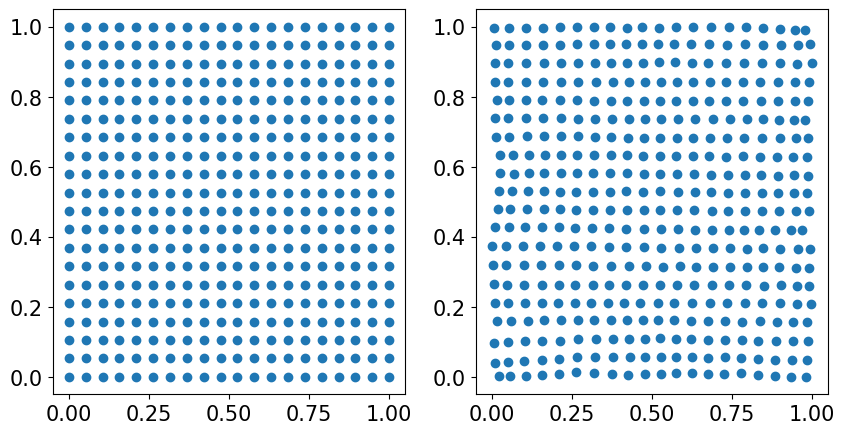

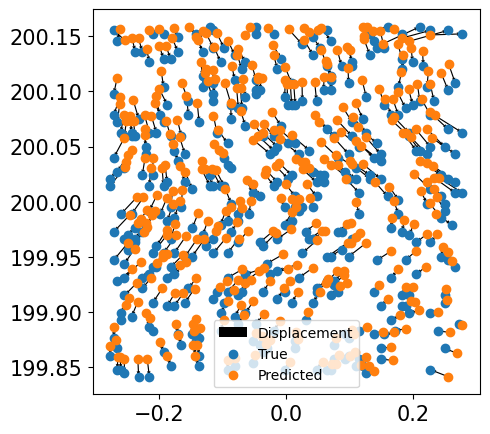

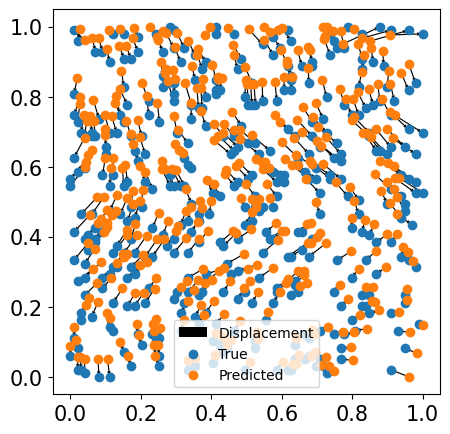

epoch: 500, train loss: 2.8436281354515813e-05, val loss: 0.0011758373584598303
epoch: 501, train loss: 2.2884933059685864e-05, val loss: 0.0010953872697427869
epoch: 502, train loss: 2.6356436137575656e-05, val loss: 0.0011756634339690208
epoch: 503, train loss: 2.7079526262241416e-05, val loss: 0.0011574391974136233
epoch: 504, train loss: 2.490636870788876e-05, val loss: 0.0011706716613844037
epoch: 505, train loss: 2.6390496714157052e-05, val loss: 0.0012712297029793262
epoch: 506, train loss: 2.2812489987700246e-05, val loss: 0.001257958821952343
epoch: 507, train loss: 2.0548013708321378e-05, val loss: 0.0011807687114924192
epoch: 508, train loss: 1.7144031517091207e-05, val loss: 0.0011688651284202933
epoch: 509, train loss: 1.7711623513605446e-05, val loss: 0.0011325110681355
epoch: 510, train loss: 1.8744065528153442e-05, val loss: 0.0010634269565343857
epoch: 511, train loss: 1.6392046745750122e-05, val loss: 0.0010543583193793893
epoch: 512, train loss: 1.4353927326737903e-0

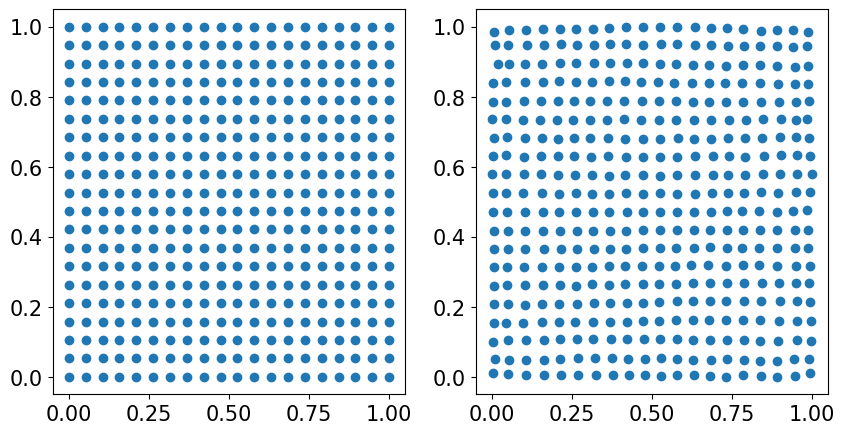

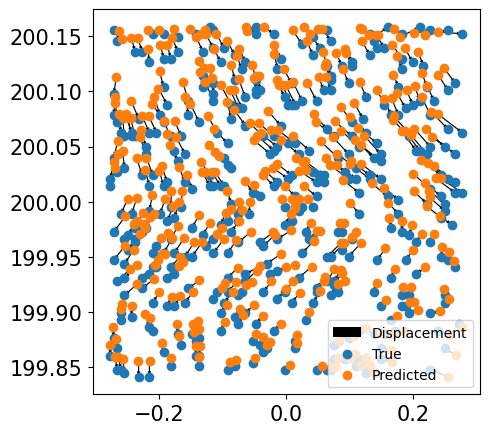

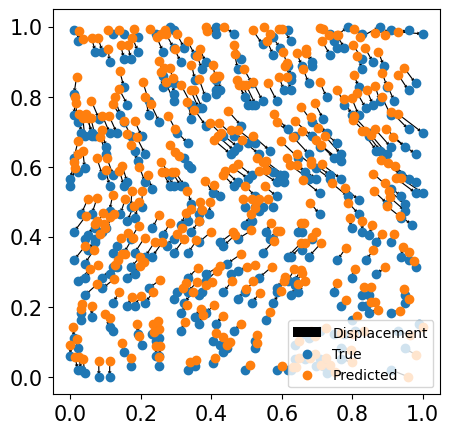

epoch: 1000, train loss: 1.6373487596865743e-05, val loss: 0.0010546843986958265
epoch: 1001, train loss: 1.4333242688735481e-05, val loss: 0.0010622756090015173
epoch: 1002, train loss: 1.787713154044468e-05, val loss: 0.0010453598806634545
epoch: 1003, train loss: 2.4684206437086686e-05, val loss: 0.0010450216941535473
epoch: 1004, train loss: 2.9979793907841668e-05, val loss: 0.0011446370044723153
epoch: 1005, train loss: 3.290137829026207e-05, val loss: 0.001121898298151791
epoch: 1006, train loss: 2.039209721260704e-05, val loss: 0.0010317201958969235
epoch: 1007, train loss: 2.2012476620147936e-05, val loss: 0.0009828723268583417
epoch: 1008, train loss: 2.2607473511015996e-05, val loss: 0.0009534239652566612
epoch: 1009, train loss: 2.4466711693094112e-05, val loss: 0.0009222793160006404
epoch: 1010, train loss: 2.7912612495128997e-05, val loss: 0.0009542912011966109
epoch: 1011, train loss: 2.3150956621975638e-05, val loss: 0.0010142737301066518
epoch: 1012, train loss: 2.27600

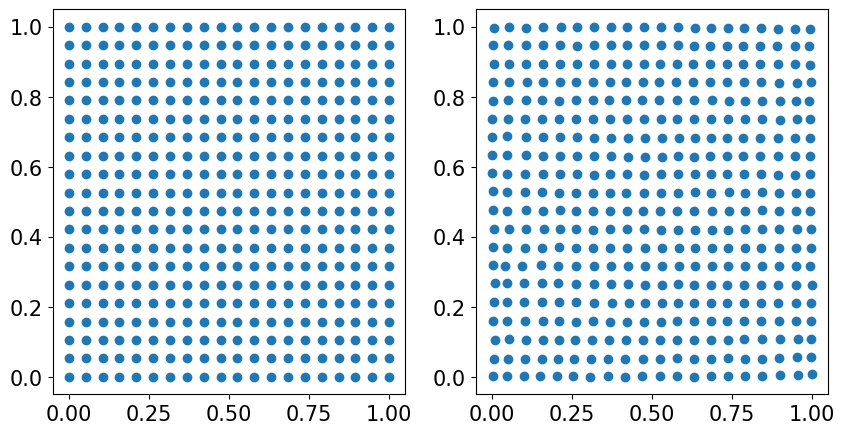

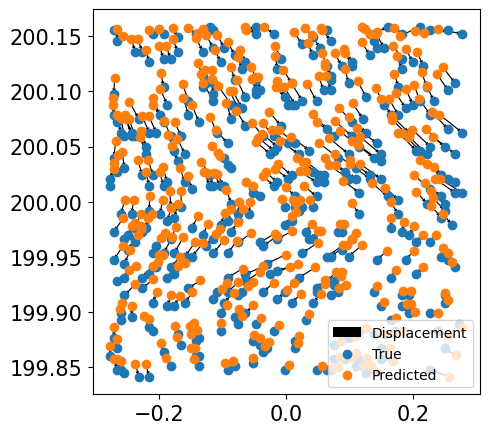

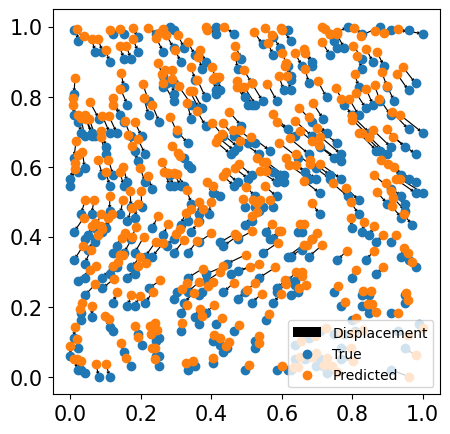

epoch: 1500, train loss: 7.149956672947155e-06, val loss: 0.0009948897641152143
epoch: 1501, train loss: 6.388660040101968e-06, val loss: 0.0009914458496496081
epoch: 1502, train loss: 4.801125669473549e-06, val loss: 0.000978647149167955
epoch: 1503, train loss: 4.7473777158302255e-06, val loss: 0.0009667329140938818
epoch: 1504, train loss: 5.765227342635626e-06, val loss: 0.0009614502196200192
epoch: 1505, train loss: 5.443803729576757e-06, val loss: 0.000960131932515651
epoch: 1506, train loss: 4.797906058229273e-06, val loss: 0.0009613312431611121
epoch: 1507, train loss: 4.342076408647699e-06, val loss: 0.0009494355181232095
epoch: 1508, train loss: 3.97300618715235e-06, val loss: 0.0009619296179153025
epoch: 1509, train loss: 3.6732881198986433e-06, val loss: 0.0009785100119188428
epoch: 1510, train loss: 3.688647439048509e-06, val loss: 0.0009961505420506
epoch: 1511, train loss: 3.3578783131815726e-06, val loss: 0.0010148602304980159
epoch: 1512, train loss: 3.582237923183129e

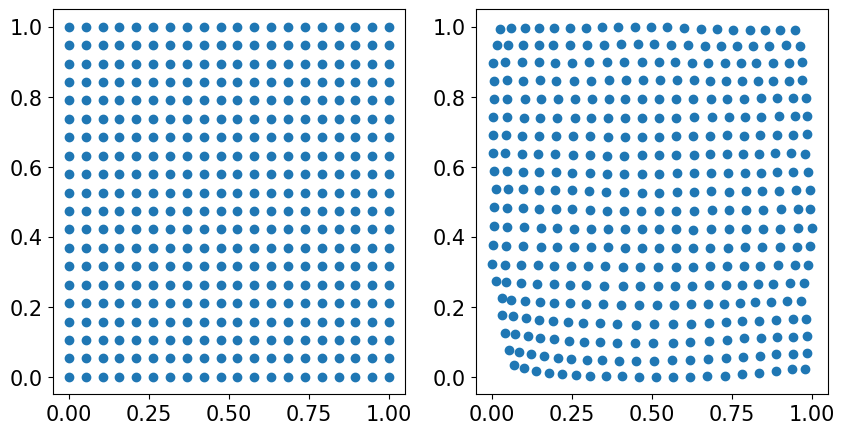

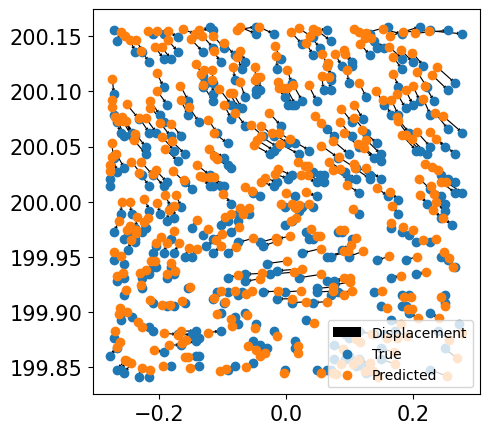

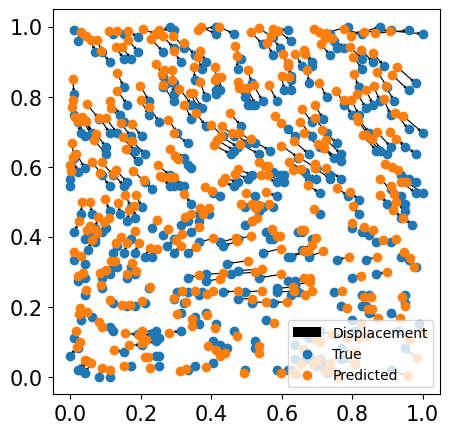

epoch: 2000, train loss: 0.00012115194840589538, val loss: 0.0008335430757142603
epoch: 2001, train loss: 0.00010803448094520718, val loss: 0.000819925800897181
epoch: 2002, train loss: 0.00011681084288284183, val loss: 0.000816750805824995
epoch: 2003, train loss: 0.00012426743342075497, val loss: 0.0008279320318251848
epoch: 2004, train loss: 0.00010217061935691163, val loss: 0.0008898409432731569
epoch: 2005, train loss: 8.333567529916763e-05, val loss: 0.0010187585139647126
epoch: 2006, train loss: 7.11806133040227e-05, val loss: 0.0009242528467439115
epoch: 2007, train loss: 6.589708937099203e-05, val loss: 0.0011508793104439974
epoch: 2008, train loss: 6.973606650717556e-05, val loss: 0.001086951931938529
epoch: 2009, train loss: 7.348327926592901e-05, val loss: 0.0009955060668289661
epoch: 2010, train loss: 7.08213119651191e-05, val loss: 0.0008800097275525331
epoch: 2011, train loss: 5.8358786191092804e-05, val loss: 0.0007986599230207503
epoch: 2012, train loss: 4.413052374729

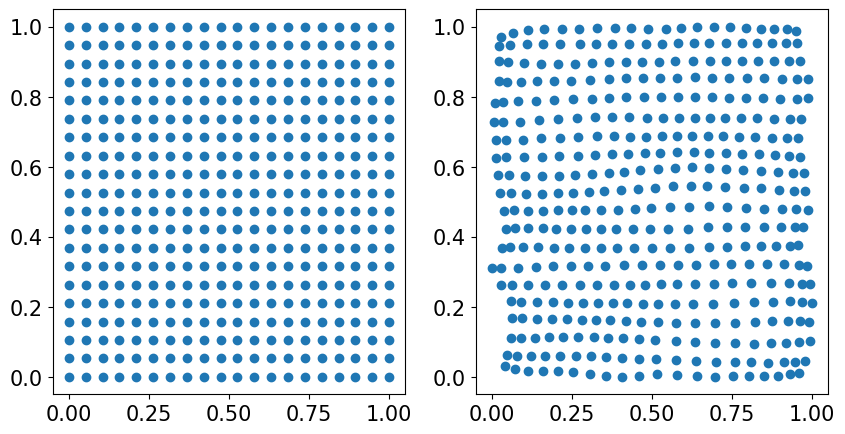

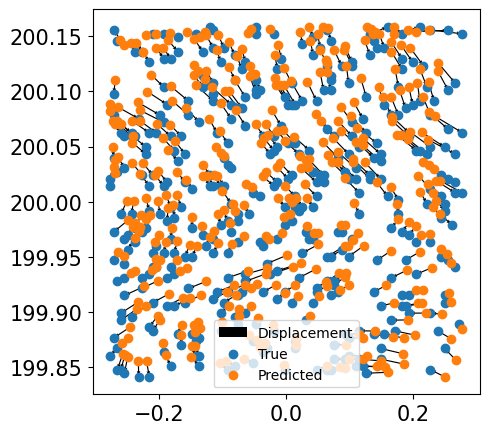

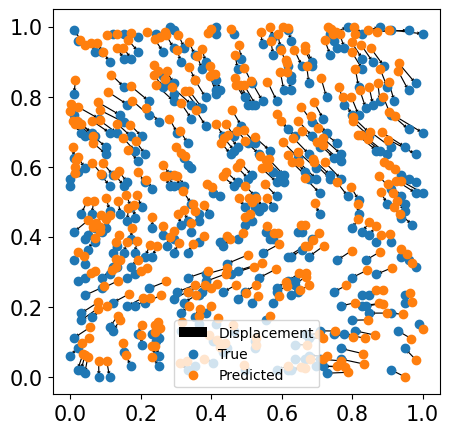

epoch: 2500, train loss: 0.00016870412218850106, val loss: 0.0010903209913522005
epoch: 2501, train loss: 0.00017206300981342793, val loss: 0.0010324696777388453
epoch: 2502, train loss: 0.00014352855214383453, val loss: 0.0010858919704332948
epoch: 2503, train loss: 0.00012041728768963367, val loss: 0.0009302744292654097
epoch: 2504, train loss: 9.873390808934346e-05, val loss: 0.0008584884344600141
epoch: 2505, train loss: 8.569975761929527e-05, val loss: 0.0008992960210889578
epoch: 2506, train loss: 9.015569230541587e-05, val loss: 0.0008732537971809506
epoch: 2507, train loss: 8.47865449031815e-05, val loss: 0.0009845487074926496
epoch: 2508, train loss: 8.057121885940433e-05, val loss: 0.0011374405585229397
epoch: 2509, train loss: 8.27500771265477e-05, val loss: 0.001088339020498097
epoch: 2510, train loss: 7.36088550183922e-05, val loss: 0.0007739749271422625
epoch: 2511, train loss: 8.026099385460839e-05, val loss: 0.0008450828026980162
epoch: 2512, train loss: 5.3322997700888

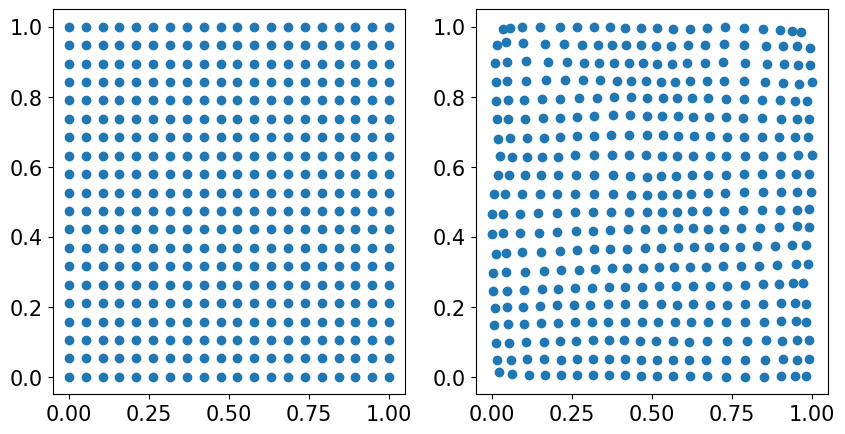

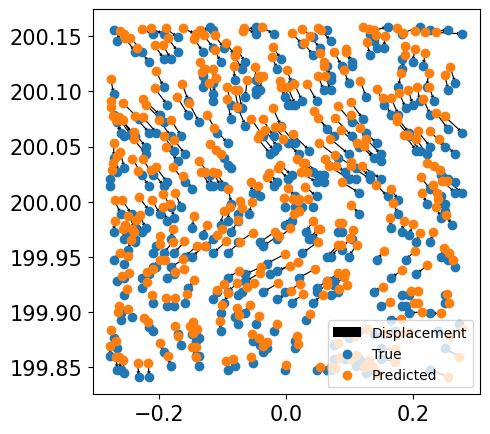

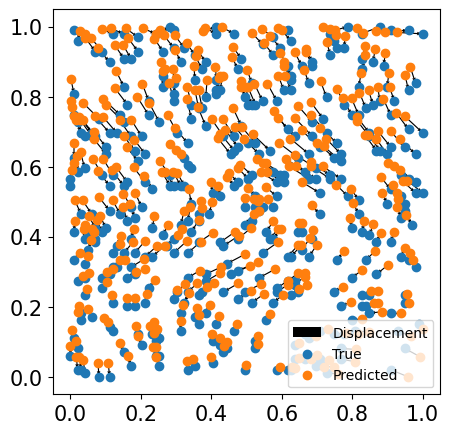

epoch: 3000, train loss: 5.867322761332616e-05, val loss: 0.0009510323288850486
epoch: 3001, train loss: 4.954249379807152e-05, val loss: 0.0009543189080432057
epoch: 3002, train loss: 4.6316010411828756e-05, val loss: 0.0008843551622703671
epoch: 3003, train loss: 4.269224882591516e-05, val loss: 0.0008413997711613774
epoch: 3004, train loss: 3.798202669713646e-05, val loss: 0.0008915846119634807
epoch: 3005, train loss: 3.317074151709676e-05, val loss: 0.0008981385035440326
epoch: 3006, train loss: 3.0385464924620464e-05, val loss: 0.0008804641547612846
epoch: 3007, train loss: 2.727233550103847e-05, val loss: 0.0008468541782349348
epoch: 3008, train loss: 2.5924220608430915e-05, val loss: 0.0008262202027253807
epoch: 3009, train loss: 2.573242636572104e-05, val loss: 0.0008201636373996735
epoch: 3010, train loss: 2.2110129066277295e-05, val loss: 0.0008271586848422885
epoch: 3011, train loss: 2.119122291333042e-05, val loss: 0.0008320931810885668
epoch: 3012, train loss: 1.936034641

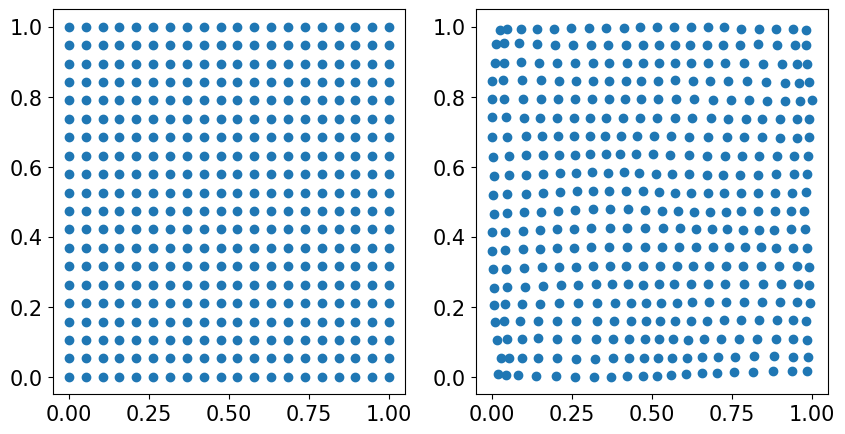

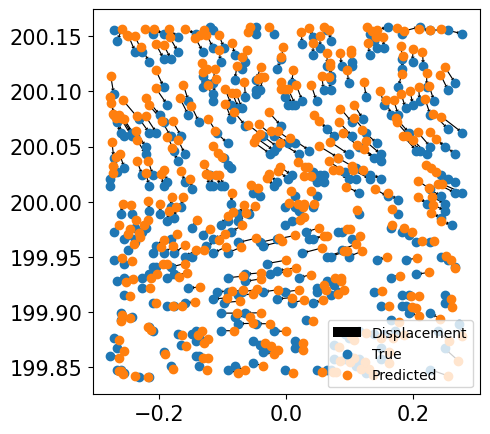

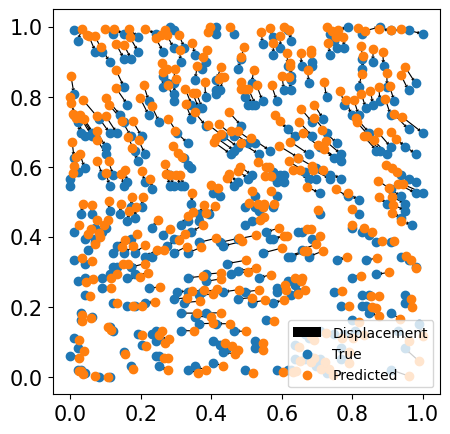

epoch: 3500, train loss: 5.98789265495725e-05, val loss: 0.0007755007245577872
epoch: 3501, train loss: 6.94140835548751e-05, val loss: 0.0007440451881848276
epoch: 3502, train loss: 7.709652709309012e-05, val loss: 0.0006857099360786378
epoch: 3503, train loss: 7.708321209065616e-05, val loss: 0.0005857524811290205
epoch: 3504, train loss: 0.00010022691276390105, val loss: 0.0008310343255288899
epoch: 3505, train loss: 0.00011798935884144157, val loss: 0.001001163967885077
epoch: 3506, train loss: 0.0001439256884623319, val loss: 0.0008262614719569683
epoch: 3507, train loss: 0.00010718478006310761, val loss: 0.0010452116839587688
epoch: 3508, train loss: 8.536552195437253e-05, val loss: 0.0011066289152950048
epoch: 3509, train loss: 0.00011641612218227237, val loss: 0.0009739657980389893
epoch: 3510, train loss: 0.00010482018842594698, val loss: 0.0008809038554318249
epoch: 3511, train loss: 0.00010534861939959228, val loss: 0.0010280058486387134
epoch: 3512, train loss: 9.7182259196

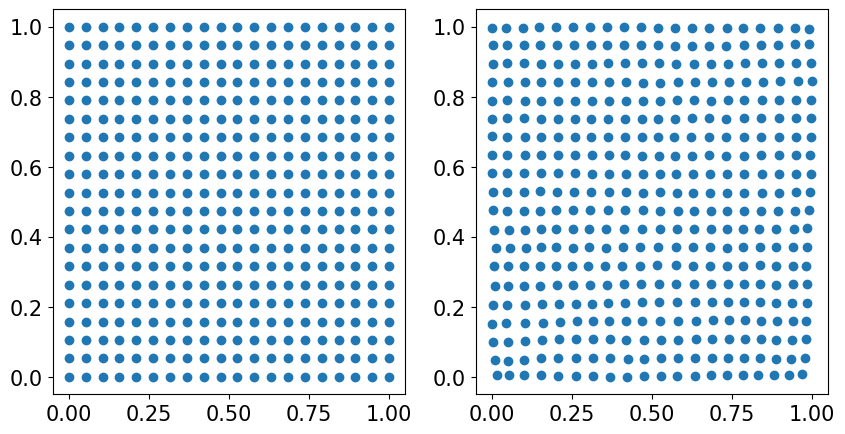

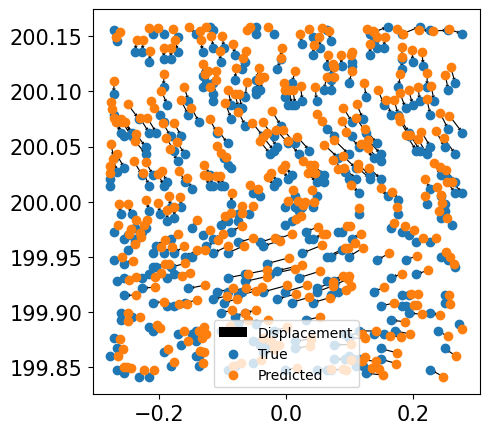

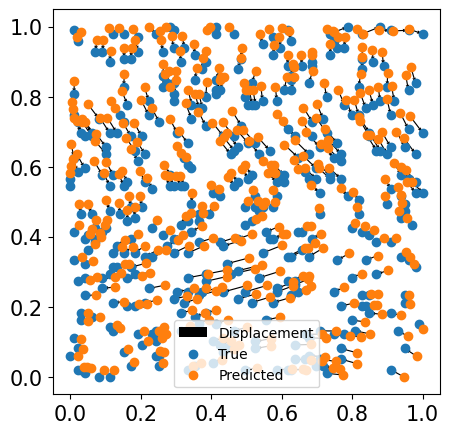

epoch: 4000, train loss: 1.8769736925605685e-05, val loss: 0.000750855659134686
epoch: 4001, train loss: 2.184798358939588e-05, val loss: 0.0007751368684694171
epoch: 4002, train loss: 2.063495594484266e-05, val loss: 0.0007888806285336614
epoch: 4003, train loss: 1.3665229744219687e-05, val loss: 0.0007684130687266588
epoch: 4004, train loss: 1.6262170902336948e-05, val loss: 0.0007538774516433477
epoch: 4005, train loss: 1.779913691279944e-05, val loss: 0.0007486983085982502
epoch: 4006, train loss: 1.3606866559712216e-05, val loss: 0.0007429416291415691
epoch: 4007, train loss: 1.1004255611624103e-05, val loss: 0.0007363651529885828
epoch: 4008, train loss: 1.2195489944133442e-05, val loss: 0.0007372198742814362
epoch: 4009, train loss: 9.752436199050862e-06, val loss: 0.0007121457019820809
epoch: 4010, train loss: 9.500899977865629e-06, val loss: 0.0007011808338575065
epoch: 4011, train loss: 1.0981047125824261e-05, val loss: 0.0007142983376979828
epoch: 4012, train loss: 9.5923951

KeyboardInterrupt: 

In [ ]:
#cc data training #(x, y) coords. Uses small grid for homo (20x20) and a 400 point random sample from 100x100 grid for random
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')

Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
#layers=[250,1000,750,500, 500, 300, 300, 400,800]
layers=[256]*12
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo')

print('training data passed')
b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)

def rescale_for_img(r,transform):
    r_ret=copy.deepcopy(r.detach())
    r_ret[:,0]=(r_ret[:,0]*transform.slope_x)+transform.intercept_x
    r_ret[:,1 ]=(r_ret[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r_ret.detach())


data_path_val=os.path.join(cwd,'Data/PNAS-regime_2xgrid_all_seeds/PNAS-regime_2xgrid_seed0')
val_data=H.data_rho_CC_XY_targs(data_path_val+'/val', 2/80000,1, grid='grid_100by100.mat')
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)
perm=np.random.permutation(len(b_val))
b_val=b_val[perm]
b_val=b_val[:400]
rho_val=rho_val[perm]
rho_val=rho_val[:400]

encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

#if torch.allclose(b_train, b_val):
#    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%500==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%500==0:
   
        
        H.plot_2_imgs_XY_displacments(rescale_for_img(rho.squeeze(), val_data), rescale_for_img(rho_hat.squeeze(),val_data), figsize=5, xpix=20, ypix=20, font_size=15)
        H.plot_2_imgs_XY_displacments((rho.squeeze()), (rho_hat.squeeze()), figsize=5, xpix=20, ypix=20, font_size=15)
        
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')






In [ ]:
H.count_parameters(transformer_encoder)

182186192

In [ ]:
#Raw data training unlabeled, only solving b---->b
target='raw'
unlabeled_data=5000
batchsize=128
layers=[1000]*8

Epochs=7000


Track_run=False
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2


encoder=M.fc_net_batch(enc_dim, layers,enc_dim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        b=b.to(device)
        b=F.normalize(b, dim=-1)
        optimizer.zero_grad()

        b_hat=encoder(b)
        b_hat=F.normalize(b_hat, dim=-1)
    
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        train_lossavg+=L2_loss.item()
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    optimizer.zero_grad()
    b_hat=encoder(b_val)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        print(f'epoch: {epoch}, train loss: {train_lossavg},val loss: {val_lossavg}')
        

In [ ]:
#cc data training #(x, y) coords. Uses small grid for homo (20x20) and a 400 point random sample from 100x100 grid for random
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')

Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo')
training_data.slope_x, training_data.intercept_x

Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)


(tensor(-0.2660), tensor(-0.2660))

Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
training data passed
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 725.0 0.5
15318018
Data shapes: 725.0 0.5


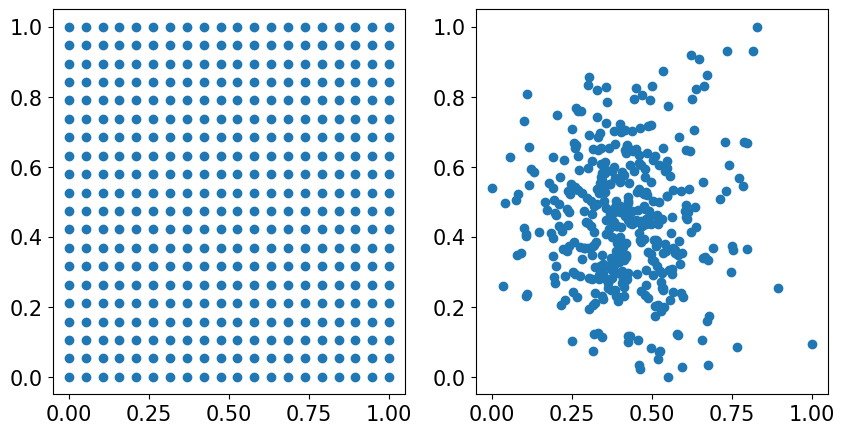

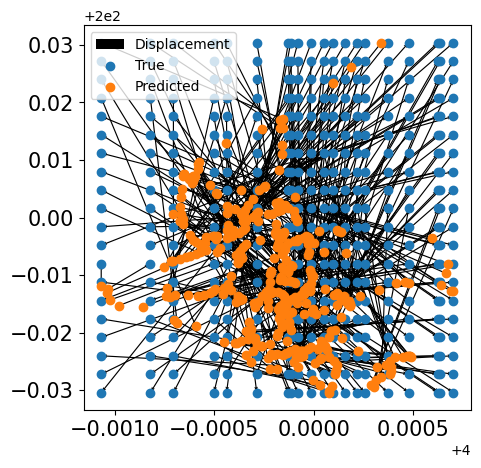

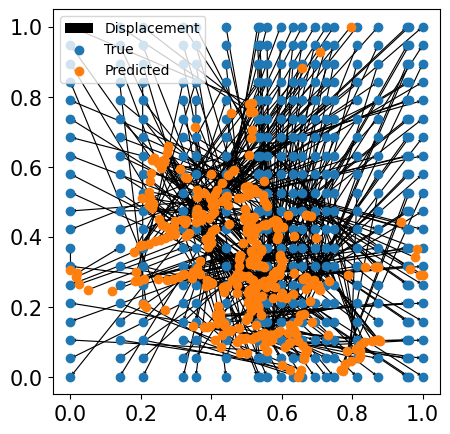

epoch: 0, train loss: 0.11268360167741776, val loss: 0.12985800206661224
epoch: 1, train loss: 0.14655360579490662, val loss: 0.15746228396892548
epoch: 2, train loss: 0.06167623773217201, val loss: 0.1756618618965149
epoch: 3, train loss: 0.02810976654291153, val loss: 0.1854751706123352
epoch: 4, train loss: 0.03224504366517067, val loss: 0.19565080106258392
epoch: 5, train loss: 0.033671069890260696, val loss: 0.20951586961746216
epoch: 6, train loss: 0.062153346836566925, val loss: 0.20505169034004211
epoch: 7, train loss: 0.03089189901947975, val loss: 0.17976665496826172
epoch: 8, train loss: 0.018750803545117378, val loss: 0.21377727389335632
epoch: 9, train loss: 0.0142426872625947, val loss: 0.22187846899032593
epoch: 10, train loss: 0.00833959598094225, val loss: 0.24430298805236816
epoch: 11, train loss: 0.0054048290476202965, val loss: 0.24298636615276337
epoch: 12, train loss: 0.00400362117215991, val loss: 0.24788028001785278
epoch: 13, train loss: 0.00366720138117671, va

KeyboardInterrupt: 

In [2]:
#cc data training #(x, y) coords. Uses small grid for homo (20x20) and a slightly (.1% pertrubed grid)
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')

Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
#layers=[250,1000,750,500, 500, 300, 300, 400,800]
layers=[256]*12
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo')

print('training data passed')
b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)

def rescale_for_img(r,transform):
    r_ret=copy.deepcopy(r.detach())
    r_ret[:,0]=(r_ret[:,0]*transform.slope_x)+transform.intercept_x
    r_ret[:,1 ]=(r_ret[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r_ret.detach())


data_path_val=os.path.join(cwd,'Data/PNAS-regime_10percent_pertgrid_all_seeds/PNAS-regime_10percent_pertgrid_seed0')
val_data=H.data_rho_CC_XY_targs(data_path_val+'/val', 2/80000,1, grid='grid_20by20_pert.mat')
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)

encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

#if torch.allclose(b_train, b_val):
#    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%500==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%500==0:
   
        
        H.plot_2_imgs_XY_displacments(rescale_for_img(rho.squeeze(), val_data), rescale_for_img(rho_hat.squeeze(),val_data), figsize=5, xpix=20, ypix=20, font_size=15)
        H.plot_2_imgs_XY_displacments((rho.squeeze()), (rho_hat.squeeze()), figsize=5, xpix=20, ypix=20, font_size=15)
        
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')






In [ ]:
def rescale_for_img(r,transform):
    r[:,0]=(r[:,0]*transform.slope_x)+transform.intercept_x
    r[:,1 ]=(r[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r.detach())

rho.shape
#rescale_for_img(rho.squeeze(), val_data)


torch.Size([400, 2])

In [ ]:
stupid=[[1,3,45,6,7,8,9,5],[1,3,45,6,7,8,9,5],[1,3,45,6,7,8,9,5],[1,3,45,6,7,8,9,5],[1,3,45,6,7,8,9,5]]
len(set(stupid[0]))!=5

True

In [ ]:
for curr_row in range(0, 9, 3):
    print(curr_row)

scp -r /Users/alexchristie/Downloads/Codes_data/PNAS-regime_10percent_pertgrid_all_seeds/PNAS-regime_10percent_pertgrid_seed0/  achristie@gp-workstation.stanford.edu:/home/achristie/RM_imaging/RM_imaging/Data/PNAS-regime_10percent_pertgrid_all_seeds/PNAS-regime_10percent_pertgrid_seed0/

0
3
6
